In [1]:
# Add project's path to system path
import os
import sys
try: 
    proj_path
except NameError:
    os.chdir('../')
    proj_path = os.getcwd()
    if proj_path not in sys.path:
        sys.path.append(proj_path)

# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx
from scipy import linalg

from codebase import utils, rewiring, rewiring_iterations, directed_modularity # custom-made functions

## Functions

In [2]:
def convert_from_adj2networkX(A,weight_d='binary'):

    edges_ind = np.where(A>0)
    num_edges = len(edges_ind[0])

    G = nx.DiGraph()   # DiGraph
    G.add_nodes_from(np.arange(A.shape[0]))

    edges_list = list()
    if weight_d == 'binary':
        for ind in np.arange(num_edges):
            edge_pair = (edges_ind[1][ind],edges_ind[0][ind])
            edges_list.append(edge_pair)
        
        G.add_edges_from(edges_list)    
    else:
        for ind in np.arange(num_edges):
            edge_pair_w = (edges_ind[1][ind],edges_ind[0][ind],A[edges_ind[0][ind],edges_ind[1][ind]])
            edges_list.append(edge_pair_w)    
        
        G.add_weighted_edges_from(edges_list)
        
        
    return G

In [3]:
def getDigraphIntermediate2HubStructure(Ax,inOutThresh):

    inDeg = np.sum(Ax,axis=1)
    outDeg = np.sum(Ax,axis=0)
    
    #bare minimum nodes should have greater than 1 in and out-degrees
    nonZeroIn = np.where(inDeg>1)[0]
    nonZeroOut = np.where(outDeg>1)[0]
    nonZeroInOut = np.intersect1d(nonZeroIn,nonZeroOut)

    inOutDeg = inDeg + outDeg
    indNodesTemp = np.where(inOutDeg>=inOutThresh)[0]
    indNodes2Use = np.intersect1d(nonZeroInOut,indNodesTemp)
    lenNodes2Use = len(indNodes2Use)

    #find the hubConv and the hubDiv
    hubConv = []; hubDiv = [] 
    for nodes in indNodes2Use:
    
        if inDeg[nodes]>outDeg[nodes]:
            hubConv.append(nodes)
        else:
            hubDiv.append(nodes)

    G = convert_from_adj2networkX(Ax)
    paths = dict(nx.all_pairs_dijkstra_path(G))
    len_paths = dict(nx.all_pairs_dijkstra_path_length(G))
            
    #find the intermediate hubs and simple nodes from hubConv to hubDiv
    intermedNodesAll = []
    for source in hubConv:
        for target in hubDiv:
          
            if target in list(paths[source].keys()):
                if len(paths[source][target])>2:
                    intermedNodesAll.extend(paths[source][target][1:-1])

    
    intermedNodes = np.unique(intermedNodesAll)    
    intermedHubs = np.intersect1d(intermedNodes, indNodes2Use)        
    #Return the unique values in intermedNodes that are not in indNodes2Use
    intermedSimpleNodes = np.setdiff1d(intermedNodes, indNodes2Use)
    
    
    return indNodes2Use,intermedHubs,intermedSimpleNodes

In [4]:
def get_inv_path_length(G):

    nodes = len(G.nodes)
    total_connections = nodes*(nodes-1)

    paths = dict(nx.all_pairs_dijkstra_path(G))
    len_paths = dict(nx.all_pairs_dijkstra_path_length(G))

    total_inv_path_len = 0
    counter = 0
    for edge in len_paths.keys():
        for conn_edge in len_paths[edge].keys():
        
            counter += 1
            len_p = len_paths[edge][conn_edge]
            if len_p>0:
                total_inv_path_len += 1/len_p
            #else:
            #    print('edge is '+str(edge)+' and connected edge is '+str(conn_edge))

            #print('%d-%d: %f'%(edge,conn_edge,len_p))
            #print('counter is %d, length of the path is %f and total path length so far is %f '%(counter,len_p,total_path_len))
            #print('')

    average_inv_path_len = total_inv_path_len/total_connections
    num_of_possible_paths = counter
    #print('average path length is %f'%average_path_len)
    return average_inv_path_len,num_of_possible_paths

In [5]:
directory_load = 'data/'

flag = '_cons_adv_50_'

file_path_load = directory_load +'A'+flag+'pRand.pckl'
A = utils.load_var(file_path_load)

pRandVec = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 1]
repetitions = 100



# Same as in Figure 5 but now we also do some statistical analysis too. You will see in the particular excerpt in the paper where I write something about p-values and more signifact and what have you.

In [6]:
inOutThresh = 15 # 20,25,30

numNodes = 100
AIntermedDict = {};ASimpleDict={};
for rep in np.arange(repetitions):
    for indP,p in enumerate(pRandVec):
        
        Ax = A[rep+1][p,1][4000]
        indNodes2Use,indIntermedHubs,indIntermedSimpleNodes = getDigraphIntermediate2HubStructure(Ax,inOutThresh)

        if len(indIntermedSimpleNodes)>0:            
            
            AIntermedDict[rep+1,p,flag] = Ax[indIntermedSimpleNodes[:, None], indIntermedSimpleNodes]
        
            #put here random nodes the size of Asubset to compare
            indSimpleNodesTemp = np.setdiff1d(np.arange(numNodes), indNodes2Use, assume_unique=False)
            indSimpleNodes = np.setdiff1d(indSimpleNodesTemp, indIntermedSimpleNodes, assume_unique=False)
            if len(indIntermedSimpleNodes) < len(indSimpleNodes):
                indRandSimpleNodes = random.sample(list(indSimpleNodes),len(indIntermedSimpleNodes))
            else:
                indRandSimpleNodes = indSimpleNodes
            
            indRandSimpleNodes = np.array(indRandSimpleNodes)

            ASimpleDict[rep+1,p,flag] = Ax[indRandSimpleNodes[:, None], indRandSimpleNodes]

        else:
            AIntermedDict[rep+1,p,flag] = np.array([])
            ASimpleDict[rep+1,p,flag] = np.array([])
            

In [7]:

pR=[0,0.2,0.4,0.6]

nodesIntermed = {}; nodesSimple = {}; connectionsIntermed = {}; connectionsSimple = {}
densityIntermed = {}; densitySimple = {}
for p in pR:
    nodesIntermed[p]= np.zeros((repetitions,1)); nodesSimple[p] = np.zeros((repetitions,1))
    connectionsIntermed[p] = np.zeros((repetitions,1));connectionsSimple[p] = np.zeros((repetitions,1))
    densityIntermed[p] = np.zeros((repetitions,1)); densitySimple[p] = np.zeros((repetitions,1))
    for rep in np.arange(repetitions):
    
        AIntermed = AIntermedDict[rep+1,p,flag]
        nodesIntermed[p][rep] = AIntermed.shape[0]
        connectionsIntermed[p][rep] = np.sum(AIntermed)
        
        if connectionsIntermed[p][rep] > 0:
            densityIntermed[p][rep] = connectionsIntermed[p][rep]/(nodesIntermed[p][rep]*(nodesIntermed[p][rep]-1))
        else:
            densityIntermed[p][rep] = 0.0
        
        ASimple = ASimpleDict[rep+1,p,flag]        
        nodesSimple[p][rep] = ASimple.shape[0]
        connectionsSimple[p][rep] = np.sum(ASimple)
        
        if connectionsSimple[p][rep] > 0:
            densitySimple[p][rep] = connectionsSimple[p][rep]/(nodesSimple[p][rep]*(nodesSimple[p][rep]-1))
        else:
            densitySimple[p][rep] = 0        
        


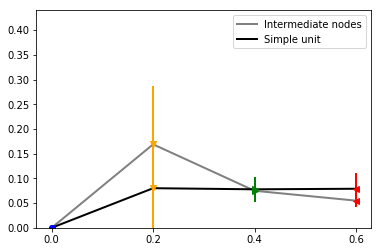

In [8]:
densityIntermedMean = np.zeros((len(pR),1))
densityIntermedStd = np.zeros((len(pR),1))

densitySimpleMean = np.zeros((len(pR),1))
densitySimpleStd = np.zeros((len(pR),1))


markers = ['o','v','>','<']
colors = ['blue','orange','green','red']

for ind,p in enumerate(pR):
    densityIntermedMean[ind] = np.mean(densityIntermed[p])
    densityIntermedStd[ind] = np.std(densityIntermed[p])
    
    densitySimpleMean[ind] = np.mean(densitySimple[p])
    densitySimpleStd[ind] = np.std(densitySimple[p])    
    

plt.plot(pR,densityIntermedMean,color='grey',linewidth=2,label='Intermediate nodes')
plt.plot(pR,densitySimpleMean,color='black',linewidth=2,label='Simple unit')
plt.legend()
plt.xticks(pR)
plt.yticks([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4])
plt.ylim([0,0.44])  
#plt.legend()
for ind in np.arange(len(densityIntermedMean)):
    plt.errorbar(pR[ind],densityIntermedMean[ind],densityIntermedStd[ind],marker= markers[ind],color=colors[ind],linewidth=2)
    plt.errorbar(pR[ind],densitySimpleMean[ind],densitySimpleStd[ind],marker= markers[ind],color=colors[ind],linewidth=2)


filePathPlot = 'data/convdiv/DensityIntermed'+str(inOutThresh)+'.eps'    

plt.savefig(filePathPlot, format='eps', dpi=1200)

In [9]:
import pandas as pd

numIterations = 100
pRand = [0,0.2,0.4,0.6]
densityType = ['Simple','Intermediate']

allDensities = []; labelsP = []; labelsType = []

counter = 0
for p in pRand:
    for den in densityType:
        
        labelsP.extend([p]*numIterations)
        
        counter +=1
        start = (counter-1)*numIterations
        end = start+numIterations
        if den is 'Simple':
            allDensities.extend(densitySimple[p])
            labelsType.extend(['Simple']*numIterations)
        else:
            allDensities.extend(densityIntermed[p])
            labelsType.extend(['Intermediate']*numIterations)

dictData = {}
dictData['type'] = labelsType
dictData['pRand'] = labelsP

allData = []
for val in allDensities:
    allData.append(val[0])
dictData['densities'] = allData
            
df = pd.DataFrame(data = dictData)




In [10]:
df

,densities,pRand,type
0,0.000000,0.0,Simple
1,0.000000,0.0,Simple
2,0.000000,0.0,Simple
3,0.000000,0.0,Simple
4,0.000000,0.0,Simple
5,0.000000,0.0,Simple
6,0.000000,0.0,Simple
7,0.000000,0.0,Simple
8,0.000000,0.0,Simple
9,0.000000,0.0,Simple


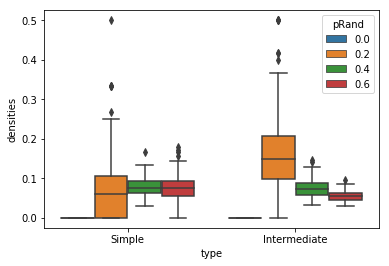

In [11]:
import seaborn as sns

sns.boxplot(x="type", y="densities", hue="pRand", data=df) 

In [12]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('densities ~ C(type) + C(pRand) + C(type):C(pRand)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(type),0.047700,1.0,15.295342,9.982690e-05
C(pRand),1.577431,3.0,168.605430,1.624402e-84
C(type):C(pRand),0.375765,3.0,40.164030,3.631409e-24
Residual,2.469920,792.0,NaN,NaN


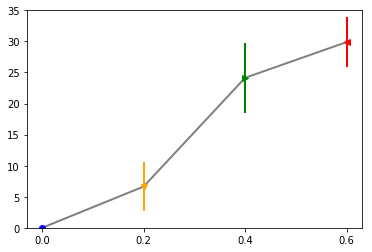

In [13]:
nodesIntermedMean = np.zeros((len(pR),1))
nodesIntermedStd = np.zeros((len(pR),1))




markers = ['o','v','>','<']
colors = ['blue','orange','green','red']

for ind,p in enumerate(pR):
    nodesIntermedMean[ind] = np.mean(nodesIntermed[p])
    nodesIntermedStd[ind] = np.std(nodesIntermed[p])   
    

plt.plot(pR,nodesIntermedMean,color='grey',linewidth=2,label='Intermediate nodes')
plt.xticks(pR)
#plt.yticks([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4])
plt.ylim([0,35])  
#plt.legend()
for ind in np.arange(len(nodesIntermedMean)):
    plt.errorbar(pR[ind],nodesIntermedMean[ind],nodesIntermedStd[ind],marker= markers[ind],color=colors[ind],linewidth=2)

filePathPlot = 'data/convdiv/NumNodesIntermed'+str(inOutThresh)+'.eps'    

plt.savefig(filePathPlot, format='eps', dpi=1200)
